In [1]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from math import *
import matplotlib.animation as animation

# ヤコビ行列の逆行列を求める
def calc_yacobian_inv(phi1, phi2, phi3, l1, l2, l3):
    yacobian = np.array([[-l1*sin(phi1) - l2*sin(phi1+phi2) - l3*sin(phi1+phi2+phi3),-l2*sin(phi1+phi2) - l3*sin(phi1+phi2+phi3),-l3*sin(phi1+phi2+phi3)],
                         [l1*cos(phi1) + l2*cos(phi1+phi2) + l3*cos(phi1+phi2+phi3),l2*cos(phi1+phi2) + l3*cos(phi1+phi2+phi3),l3*cos(phi1+phi2+phi3)],
                         [1,1,1]])
    try:
        yacobian_inv = np.linalg.inv(yacobian) #ヤコビ行列の逆行列を求める
    except:
        yacobian_inv = np.linalg.pinv(yacobian) #正則で求められないとき疑似逆行列を求める

    return yacobian_inv

# 追従させる軌道 直線 端点の2つの座標を与える.  binは時間の分割数. 各時刻における所望の座標のリストを返す(indexは分割数個)
def calc_line_coodinate(start,end,bin):
    x1 = start[0]
    y1 = start[1]
    x2 = end[0]
    y2 = end[1]

    x_refs = []
    y_refs = []
    for i in range(bin+1):
        x = (x2-x1)*(i/bin) + x1
        y = (y2-y1)*(i/bin) + y1
        x_refs.append(x)
        y_refs.append(y)

    return x_refs, y_refs

# 追従させる軌道 直線 端点の2つの座標を与える.  req_tは処理時間. 各時刻における所望の座標のリストを返す(indexは分割数個)
def calc_line_coodinate_bytime(start, end, req_t):
    cur_t = 0
    x_refs = []
    y_refs = []
    while(cur_t < req_t):
        s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
        x_ref = start[0]*(1-s) + end[0]*s
        y_ref = start[1]*(1-s) + end[1]*s
        x_refs.append(x_ref)
        y_refs.append(y_ref)
        cur_t += 1
    
    return x_refs, y_refs

# 追従させる軌道 円 始点と回転角を与える
def calc_circle_coodinate(start,theta,bin):
    x_refs = []
    y_refs = []
    x1 = start[0]
    y1 = start[1]
    x_refs.append(x1)
    y_refs.append(y1)
    for i in range(bin+1):
        # 回転行列を計算
        r_mat = np.array([[cos(theta/bin),-sin(theta/bin)],
                          [sin(theta/bin), cos(theta/bin)]])
        
        x = np.array([[x1],
                      [y1]])
        
        x_new = np.dot(r_mat, x)
        x1 = x_new[0][0]
        y1 = x_new[1][0]
        x_refs.append(x1)
        y_refs.append(y1)
    
    return x_refs, y_refs
    
# 順運動学で第一関節の位置を計算
def calc_cur_first_pos(l1,phi1):
    x = l1*cos(phi1)
    y = l1*sin(phi1)
    cur_first_pos = [x,y]

    return cur_first_pos

# 順運動学で第二関節の位置を計算
def calc_cur_second_pos(l1,l2,phi1,phi2):
    x = l1*cos(phi1) + l2*cos(phi1+phi2)
    y = l1*sin(phi1) + l2*sin(phi1+phi2)
    cur_second_pos = [x,y]

    return cur_second_pos

# 順運動学で現在の関節角度から手先位置を計算
def calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3):
    x = l1*cos(phi1) + l2*cos(phi1+phi2) + l3*cos(phi1+phi2+phi3)
    y = l1*sin(phi1) + l2*sin(phi1+phi2) + l3*sin(phi1+phi2+phi3)
    alpha = phi1+phi2+phi3

    cur_hand_pos = np.array([[x],
                             [y],
                             [alpha]])

    return cur_hand_pos

# 加える関節角度Φ1,Φ2,Φ3を求める cur_posは3×1行列 [x,y,alpha] (numpy_array)
def calc_added_angle(cur_pos, x_refs, y_refs, index, yacobian_inv):
    goal_pos = np.array([[x_refs[index]],
                         [y_refs[index]],
                         [0]]) #αは0とする
    dif_pos = goal_pos - cur_pos # 現在位置との差
    added_angles = np.dot(yacobian_inv, dif_pos) # 加えるべき関節角度の配列

    return added_angles

<IPython.core.display.Javascript object>


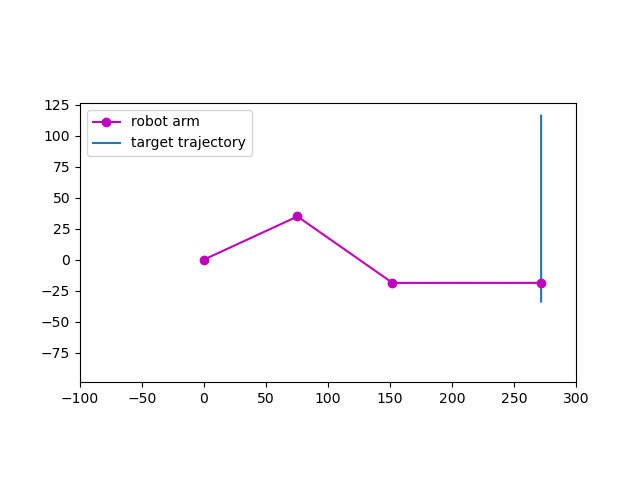

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


done


In [15]:
# params
phi1 = 0.3
phi2 = 0.2
phi3 = -0.1

# リンクの長さ
l1 = 83
l2 = 93.5
l3 = 120

# 初期位置
cur_hand_pos = calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3)

# 円軌道用
req_t = 10000
theta = -pi/4

# 直線軌道用
start = [cur_hand_pos[0][0], cur_hand_pos[1][0]]
end = [cur_hand_pos[0][0], cur_hand_pos[1][0] - 150]
#x_refs, y_refs = calc_line_coodinate(start,end,req_t)
x_refs, y_refs = calc_line_coodinate_bytime(start,end,req_t)
#x_refs, y_refs = calc_circle_coodinate(start,theta,req_t)

# 描画用
ims = []
fig = plt.figure()
flag_legend = True

# iteration
for i in range(req_t):
    # 各関節の現在位置を計算
    cur_first_pos = calc_cur_first_pos(l1,phi1)
    cur_second_pos = calc_cur_second_pos(l1,l2,phi1,phi2)
    cur_hand_pos = calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3)
    
    # 目標値との誤差  1で初期化
    error1 = 1
    error2 = 1
    
    while (error1 > 1e-8 or error2 > 1e-8):
        # ヤコビ行列を計算し、関節を追加する
        yacobian_inv = calc_yacobian_inv(l1,l2,l3,phi1,phi2,phi3)
        added_angles = calc_added_angle(cur_hand_pos, x_refs, y_refs, i, yacobian_inv)
        
        # チューニングゲイン
        K = 0.6
        phi1 += K*added_angles[0][0]
        phi2 += K*added_angles[1][0]
        phi3 += K*added_angles[2][0]
        
        cur_hand_pos = calc_cur_hand_pos(l1,l2,l3,phi1,phi2,phi3)
        error1 = x_refs[i] - cur_hand_pos[0][0]
        error2 = y_refs[i] - cur_hand_pos[0][0]
    
    #プロット用 遅くなるので5回に1回表示
    if i%10 == 0:
        im = plt.plot([0,cur_first_pos[0],cur_second_pos[0],cur_hand_pos[0][0]],[0,cur_first_pos[1],cur_second_pos[1],cur_hand_pos[1][0]],'b-o',label="robot arm",color="m")
        ims.append(im)
    if flag_legend: # 一回のみ凡例を描画
        plt.plot(x_refs,y_refs,label="target trajectory")
        #plt.ylim(-2,2)
        plt.xlim(-100,300)
        plt.axes().set_aspect('equal')
        plt.legend()
        flag_legend = False


ani = animation.ArtistAnimation(fig, ims, interval=1)
#ani.save('circle_compliance.gif', writer='pillow', fps=50)
fig.show()
print("done")